In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [2]:
!nvidia-smi

Sun Apr 28 17:03:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   35C    P2    37W / 198W |      2MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils.utils import get_train, convert
from utils.preprocess import preprocess_sentence, max_length, tokenize
from models.encoder import Encoder
from models.decoder import Decoder
from models.bahdanauattention import BahdanauAttention
from models.keyvalueattention import KeyValueAttention


import re
import numpy as np
import os
import io
import time

In [4]:
tf.__version__

'2.0.0-alpha0'

In [6]:
%%time
df = get_train(nrows=10000)

CPU times: user 1.61 s, sys: 398 ms, total: 2 s
Wall time: 2.16 s


In [9]:
df_train = df.copy()
df_train['firstSentence'] = np.vectorize(preprocess_sentence)(df_train['firstSentence'])
df_train['secondSentence'] = np.vectorize(preprocess_sentence)(df_train['secondSentence'])
df_train.head(10)

,firstSentence,secondSentence
0,"<start> you ' re not alone , claire . <end>","<start> you are not alone , claire . <end>"
1,"<start> who told you to throw acid at vargas ,...",<start> who told you to throw acid at vargas ?...
2,<start> where the pure angel merges with the a...,<start> where the pure angel merges with the a...
3,<start> where is it written what is it i ' m m...,<start> where is it written what it is i ' m m...
4,<start> we ' ll find the skipper and then we '...,<start> we ' ll find the skipper and then we g...
5,<start> seymour ' s darling is third . . . and...,<start> seymour ' s darling is third . . . and...
6,"<start> scud , do you read me ? <end>","<start> scud , you reading me ? <end>"
7,<start> jumby now wants to be born . <end>,<start> jumby want birth . <end>
8,<start> it was a difficult and long delivery ....,<start> the delivery was difficult and long . ...
9,"<start> it ' s a shit , but it ' s better than...","<start> it ' s a shit , but it ' s better that..."


In [10]:
%%time
input_tensor, inp_tokenizer = tokenize(df_train['firstSentence'].values.tolist())
target_tensor, targ_tokenizer = tokenize(df_train['secondSentence'].values.tolist())
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

CPU times: user 272 ms, sys: 328 µs, total: 272 ms
Wall time: 275 ms


In [11]:
convert(inp_tokenizer, input_tensor_train[5])
convert(targ_tokenizer, target_tensor_train[4])

1	<start>
20	he
95	didn
4	'
18	t
367	even
107	say
928	goodbye
3	.
2	<end>
1	<start>
143	sorry
8	,
49	will
3	.
2	<end>


In [12]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_tokenizer.word_index)+1
vocab_tar_size = len(targ_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 26]), TensorShape([64, 27]))

In [13]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [14]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_tokenizer.word_index['<start>']] *
                                   BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden,
                                                 enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [15]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [18]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Encoder output shape: (batch size, sequence length, units) (64, 26, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)
Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 26, 1)
Decoder output shape: (batch_size, vocab size) (64, 3264)


In [20]:
checkpoint_dir = './training_checkpoints_3'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [21]:
EPOCHS = 10
for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9105
Epoch 1 Batch 100 Loss 0.8551
Epoch 1 Loss 0.9933
Time taken for 1 epoch 41.818681478500366 sec

Epoch 2 Batch 0 Loss 0.8360
Epoch 2 Batch 100 Loss 0.6933
Epoch 2 Loss 0.7185
Time taken for 1 epoch 22.642045259475708 sec

Epoch 3 Batch 0 Loss 0.6773
Epoch 3 Batch 100 Loss 0.5879
Epoch 3 Loss 0.6015
Time taken for 1 epoch 22.469702005386353 sec

Epoch 4 Batch 0 Loss 0.5917
Epoch 4 Batch 100 Loss 0.4939
Epoch 4 Loss 0.5153
Time taken for 1 epoch 22.62120246887207 sec

Epoch 5 Batch 0 Loss 0.5088
Epoch 5 Batch 100 Loss 0.4149
Epoch 5 Loss 0.4386
Time taken for 1 epoch 22.43719506263733 sec

Epoch 6 Batch 0 Loss 0.4273
Epoch 6 Batch 100 Loss 0.3515
Epoch 6 Loss 0.3731
Time taken for 1 epoch 22.721723079681396 sec

Epoch 7 Batch 0 Loss 0.3596
Epoch 7 Batch 100 Loss 0.2819
Epoch 7 Loss 0.3118
Time taken for 1 epoch 22.559738159179688 sec

Epoch 8 Batch 0 Loss 0.2918
Epoch 8 Batch 100 Loss 0.2309
Epoch 8 Loss 0.2523
Time taken for 1 epoch 22.745192050933838 sec

Ep

In [77]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_tokenizer.word_index[i] for i in sentence.split(' ') if i in inp_tokenizer.word_index]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        
        result += targ_tokenizer.index_word[predicted_id] + ' '

        if targ_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [ ]:
def re_parapharse(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted re_parapharse: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [28]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [29]:
df.tail(10)

,firstSentence,secondSentence
9990,Look at the bright side .,Look on the bright side .
9991,Khaleesi .,"Oh , Khaleesi ."
9992,Shall we continue ?,Shall we go on ?
9993,I 've already got a job .,I already got a job .
9994,Bag .,The bag .
9995,What are we gonna do with him ?,What do we do with him ?
9996,Are you back ?,You came back ?
9997,"Yeah , I 've noticed .","Yeah , I noticed ."
9998,What 's for dinner ?,What 's for supper ?
9999,Where 's Dad ?,Where is dad ?


In [ ]:
for x in df.iloc[2000:2010, :].firstSentence.values:
    try:
        re_parapharse(x)
    except Exception as e:
        pass

In [41]:
from nltk.translate import bleu
from nltk.translate.bleu_score import SmoothingFunction
def test_blue(expected, candidate):
    candidate = candidate.split(' ')
    expected = expected.split(' ')
    reference = [expected]
    smoothie = SmoothingFunction().method4
    return bleu([expected], candidate, smoothing_function=smoothie)

In [68]:
test_input_text = df.iloc[4900:5000, :].firstSentence.values
test_output_text = df.iloc[4900:5000, :].secondSentence.values

0.25899290381849804
<start> 5 , 000 . <end>
two thousand . 
Five thousand .


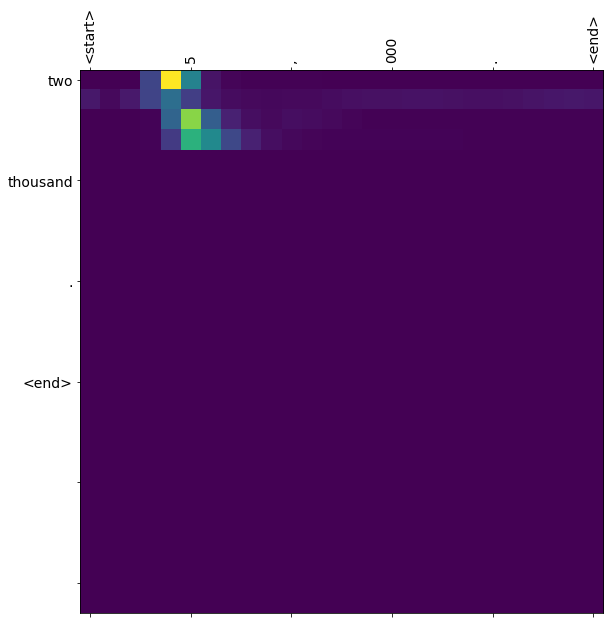

0.27759395109587814

In [70]:
blues = []
for i in range(100):
    result, sentence, attention_plot = evaluate(test_input_text[i])
    new_result = result.replace('<start> ', '').replace(' <end>', '')
    new_sentence = sentence.replace('<start> ', '').replace(' <end>', '')
    blue = test_blue(test_output_text[i], new_result)
    blues.append(blue)
    if i == 81:
        print(blue)
        print(sentence)
        print(new_result)
        print(test_output_text[i])
        plot_attention(attention_plot, sentence.split(' '), result.split(' '))
np.average(blues)

In [60]:
np.average(blues) * 100

27.759395109587814

In [50]:
np.min(blues) * 100

0.0

In [51]:
np.max(blues)*100

75.98356856515926

In [44]:
blues

[0.2941299913461552,
 0.28650723815426243,
 0.23796564142073365,
 0.20798131143120685,
 0.18665471083173696,
 0.2875833792374545,
 0.23640501160890146,
 0.26335227287021584,
 0.3655552228545123,
 0.15948194035504248,
 0.35772459775085663,
 0.13374394457703614,
 0.3655552228545123,
 0.09673068649579478,
 0.23016915699647844,
 0.27727758246450607,
 0.19879212680993805,
 0.26762649011537704,
 0.19817632389021378,
 0.26762649011537704,
 0.5081327481546147,
 0.32756475929865714,
 0.19879212680993805,
 0.2450324327954738,
 0.19879212680993805,
 0.20170387630378334,
 0.23016915699647844,
 0.18665471083173696,
 0.23728353900810106,
 0.2984745896009823,
 0.35772459775085663,
 0.23681572145316945,
 0.23016915699647844,
 0.30483335667394,
 0.25899290381849804,
 0.26762649011537704,
 0.19473925601061473,
 0.18665471083173696,
 0.668740304976422,
 0.23640501160890146,
 0.26335227287021584,
 0.35772459775085663,
 0.23796564142073365,
 0.2450324327954738,
 0.35772459775085663,
 0.2450324327954738,
 0

In [88]:
def demo(text):
    test = preprocess_sentence(text)
    result, sentence, attention_plot = evaluate(test)
    print('input:', text)
    print('predict:', result)

In [89]:
demo("You'll never walk alone")

input: You'll never walk alone
predict: you ' ll get me here . <end> 


In [90]:
demo("You're not alone")

input: You're not alone
predict: you ' re not alone . <end> 


In [95]:
demo("I 've already got a job .	")

input: I 've already got a job .	
predict: i ' m a little work . <end> 


In [98]:
demo("It was a difficult and long delivery .")

input: It was a difficult and long delivery .
predict: it was just a matter of death . <end> 
